##### Copyright 2018 The TensorFlow Authors.

# Basic regression: Predict fuel efficiency

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/regression"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/regression.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/keras/regression.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/keras/regression.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In a *regression* problem, we aim to predict the output of a continuous value, like a price or a probability. Contrast this with a *classification* problem, where we aim to select a class from a list of classes (for example, where a picture contains an apple or an orange, recognizing which fruit is in the picture).

This notebook uses the classic [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) Dataset and builds a model to predict the fuel efficiency of late-1970s and early 1980s automobiles. To do this, we'll provide the model with a description of many automobiles from that time period. This description includes attributes like: cylinders, displacement, horsepower, and weight.

This example uses the `tf.keras` API, see [this guide](https://www.tensorflow.org/guide/keras) for details.

In [1]:
# Use seaborn for pairplot
#!pip install -q seaborn

# Use some functions from tensorflow_docs
#!pip install -q git+https://github.com/tensorflow/docs

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.0.0


In [4]:
#import tensorflow_docs as tfdocs
#import tensorflow_docs.plots
#import tensorflow_docs.modeling

## The Auto MPG dataset

The dataset is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/).


### Get the data
First download the dataset.

In [5]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'C:\\Users\\pc-01\\.keras\\datasets\\auto-mpg.data'

Import it using pandas

In [6]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


### Clean the data

The dataset contains a few unknown values.

In [7]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

To keep this initial tutorial simple drop those rows.

In [8]:
dataset = dataset.dropna()

In [9]:
origin = dataset.pop('Origin')

In [10]:
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


The `"Origin"` column is really categorical, not numeric. So convert that to a one-hot:

In [11]:
#dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [12]:
#dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')        #prefix=字段名加前缀
#dataset.tail()

### Split the data into train and test

Now split the dataset into a training set and a test set.

We will use the test set in the final evaluation of our model.

frac=0.8 , 抽取行数比例  
random_state=1,可以取得重复数据

In [13]:
train_dataset = dataset.sample(frac=0.8,random_state=0)              
test_dataset = dataset.drop(train_dataset.index)

### Inspect the data

Have a quick look at the joint distribution of a few pairs of columns from the training set.  
要插入import matplotlib.pyplot as plt 和 plt.shwo() jupyter才能显示图形  
kde是密度图

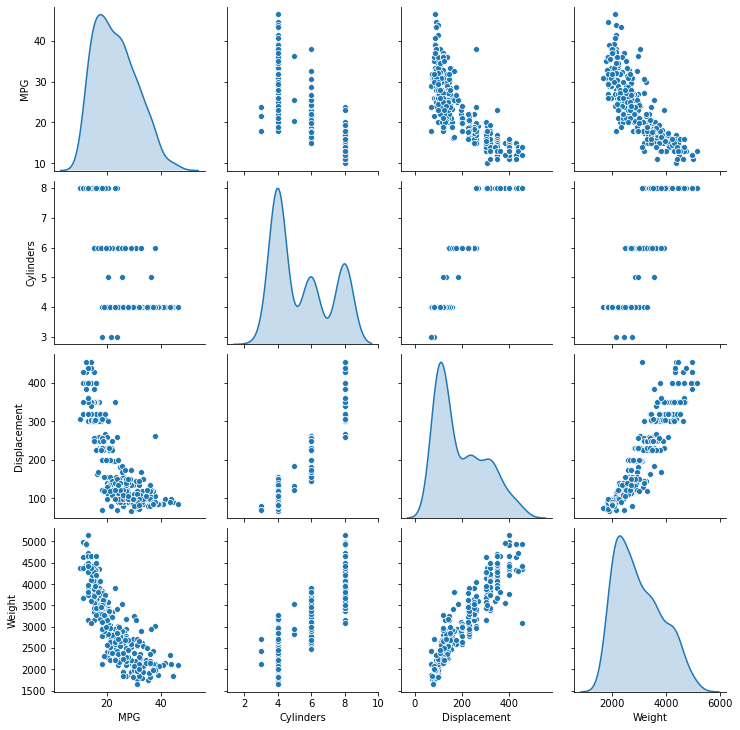

In [14]:
import matplotlib.pyplot as plt

g = sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")
plt.show()

Also look at the overall statistics:

In [15]:
train_stats = train_dataset.describe()
train_stats

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
count,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000
mean,23.310510,5.477707,195.318471,104.869427,2990.251592,15.559236,75.898089,0.624204,0.178344,0.197452
std,7.728652,1.699788,104.331589,38.096214,843.898596,2.789230,3.675642,0.485101,0.383413,0.398712
min,10.000000,3.000000,68.000000,46.000000,1649.000000,8.000000,70.000000,0.000000,0.000000,0.000000
25%,17.000000,4.000000,105.500000,76.250000,2256.500000,13.800000,73.000000,0.000000,0.000000,0.000000
50%,22.000000,4.000000,151.000000,94.500000,2822.500000,15.500000,76.000000,1.000000,0.000000,0.000000
75%,28.950000,8.000000,265.750000,128.000000,3608.000000,17.200000,79.000000,1.000000,0.000000,0.000000
max,46.600000,8.000000,455.000000,225.000000,5140.000000,24.800000,82.000000,1.000000,1.000000,1.000000


In [16]:
train_stats = train_dataset.describe()        # 信息估计coutn\mean\std\min\max
train_stats.pop("MPG")
train_stats = train_stats.transpose()         # 行列 反转 转置
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


### Split features from labels

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [17]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

### Normalize the data

Look again at the `train_stats` block above and note how different the ranges of each feature are.

It is good practice to normalize features that use different scales and ranges. Although the model *might* converge without feature normalization, it makes training more difficult, and it makes the resulting model dependent on the choice of units used in the input.

Note: Although we intentionally generate these statistics from only the training dataset, these statistics will also be used to normalize the test dataset. We need to do that to project the test dataset into the same distribution that the model has been trained on.

In [18]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

This normalized data is what we will use to train the model.

Caution: The statistics used to normalize the inputs here (mean and standard deviation) need to be applied to any other data that is fed to the model, along with the one-hot encoding that we did earlier.  That includes the test set as well as live data when the model is used in production.

## The model

### Build the model

Let's build our model. Here, we'll use a `Sequential` model with two densely connected hidden layers, and an output layer that returns a single, continuous value. The model building steps are wrapped in a function, `build_model`, since we'll create a second model, later on.

In [19]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)          # 学习率=0.001

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [20]:
model = build_model()

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [22]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.19202876],
       [ 0.20082079],
       [ 0.24218711],
       [ 0.49258944],
       [ 0.1507439 ],
       [ 0.2153003 ],
       [ 0.17326339],
       [ 0.35561085],
       [ 0.15649258],
       [-0.04314554]], dtype=float32)

It seems to be working, and it produces a result of the expected shape and type.

### Train the model

Train the model for 1000 epochs, and record the training and validation accuracy in the `history` object.

In [23]:
# EPOCHS = 1000

# history = model.fit(
#   normed_train_data, train_labels,
#   epochs=EPOCHS, validation_split = 0.2, verbose=0,
#   callbacks=[tfdocs.modeling.EpochDots()])

In [24]:
# 通过为每个完成的时期打印一个点来显示训练进度
# 对模型进行1000个周期的训练，并在 history 对象中记录训练和验证的准确性。
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

Visualize the model's training progress using the stats stored in the `history` object.

In [36]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
58,6.608476,1.838426,6.608475,8.716331,2.226963,8.716331,58
59,6.480863,1.778637,6.480863,8.532566,2.206485,8.532566,59
60,6.557962,1.789886,6.557962,8.822613,2.302416,8.822613,60
61,6.735919,1.794663,6.735919,8.695832,2.202723,8.695832,61
62,6.448900,1.771790,6.448900,8.507052,2.184830,8.507052,62


In [26]:
# plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

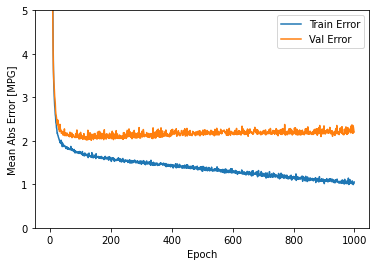

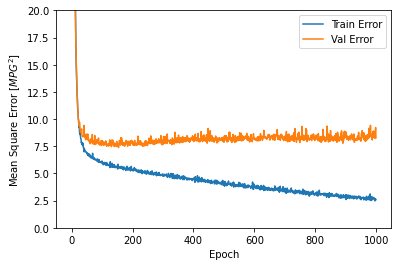

In [27]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

In [28]:
# plotter.plot({'Basic': history}, metric = "mae")
# plt.ylim([0, 10])
# plt.ylabel('MAE [MPG]')

In [29]:
# plotter.plot({'Basic': history}, metric = "mse")
# plt.ylim([0, 20])
# plt.ylabel('MSE [MPG^2]')

This graph shows little improvement, or even degradation in the validation error after about 100 epochs. Let's update the `model.fit` call to automatically stop training when the validation score doesn't improve. We'll use an *EarlyStopping callback* that tests a training condition for  every epoch. If a set amount of epochs elapses without showing improvement, then automatically stop the training.

You can learn more about this callback [here](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping).

In [30]:
# model = build_model()

# # The patience parameter is the amount of epochs to check for improvement
# early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# early_history = model.fit(normed_train_data, train_labels, 
#                     epochs=EPOCHS, validation_split = 0.2, verbose=0, 
#                     callbacks=[early_stop, tfdocs.modeling.EpochDots()])

EarlyStopping的参数有

monitor: 监控的数据接口，有’acc’,’val_acc’,’loss’,’val_loss’等等。正常情况下如果有验证集，就用’val_acc’或者’val_loss’。
    但是因为笔者用的是5折交叉验证，没有单设验证集，所以只能用’acc’了。  
min_delta：增大或减小的阈值，只有大于这个部分才算作improvement。这个值的大小取决于monitor，也反映了你的容忍程度。
例如笔者的monitor是’acc’，同时其变化范围在70%-90%之间，所以对于小于0.01%的变化不关心。
加上观察到训练过程中存在抖动的情况（即先下降后上升），所以适当增大容忍程度，最终设为0.003%。  
patience：能够容忍多少个epoch内都没有improvement。这个设置其实是在抖动和真正的准确率下降之间做tradeoff。
如果patience设的大，那么最终得到的准确率要略低于模型可以达到的最高准确率。如果patience设的小，那么模型很可能在前期抖动，
还在全图搜索的阶段就停止了，准确率一般很差。patience的大小和learning rate直接相关。在learning rate设定的情况下，
前期先训练几次观察抖动的epoch number，比其稍大些设置patience。在learning rate变化的情况下，建议要略小于最大的抖动epoch number。
笔者在引入EarlyStopping之前就已经得到可以接受的结果了，EarlyStopping算是锦上添花，所以patience设的比较高，
设为抖动epoch number的最大值。  
mode: 就’auto’, ‘min’, ‘,max’三个可能。如果知道是要上升还是下降，建议设置一下。笔者的monitor是’acc’，所以mode=’max’。



....................................................................................

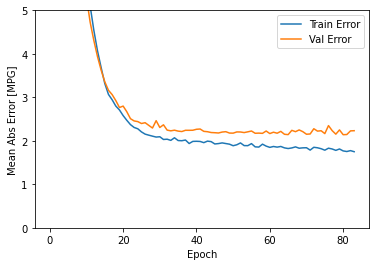

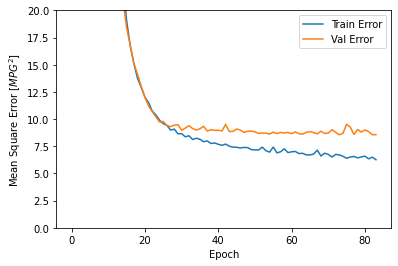

In [45]:
model = build_model()

# patience 值用来检查改进 epochs 的数量
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(early_history)

In [47]:

hist = pd.DataFrame(early_history.history)
hist['epoch'] = early_history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
79,6.518162,1.812467,6.518162,8.808086,2.250636,8.808086,79
80,6.589391,1.767907,6.589391,9.003236,2.140870,9.003236,80
81,6.341215,1.754215,6.341215,8.847796,2.144941,8.847795,81
82,6.500040,1.774626,6.500040,8.566979,2.228841,8.566979,82
83,6.260492,1.749976,6.260492,8.567473,2.232682,8.567472,83


The graph shows that on the validation set, the average error is usually around +/- 2 MPG. Is this good? We'll leave that decision up to you.

Let's see how well the model generalizes by using the **test** set, which we did not use when training the model.  This tells us how well we can expect the model to predict when we use it in the real world.

In [32]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

78/78 - 0s - loss: 5.4987 - mae: 1.7607 - mse: 5.4987
Testing set Mean Abs Error:  1.76 MPG


### Make predictions

Finally, predict MPG values using data in the testing set:

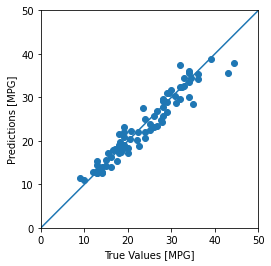

In [33]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
plt.show()

It looks like our model predicts reasonably well. Let's take a look at the error distribution.

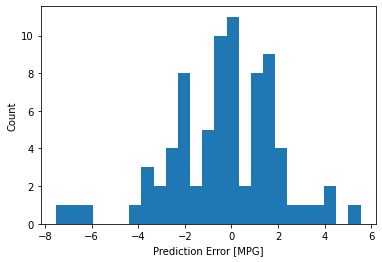

In [34]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")
plt.show()

It's not quite gaussian, but we might expect that because the number of samples is very small.

## Conclusion

This notebook introduced a few techniques to handle a regression problem.

* Mean Squared Error (MSE) is a common loss function used for regression problems (different loss functions are used for classification problems).
* Similarly, evaluation metrics used for regression differ from classification. A common regression metric is Mean Absolute Error (MAE).
* When numeric input data features have values with different ranges, each feature should be scaled independently to the same range.
* If there is not much training data, one technique is to prefer a small network with few hidden layers to avoid overfitting.
* Early stopping is a useful technique to prevent overfitting.